## Imports

In [1]:
import os
import sys
import pandas as pd
import sys
import altair as alt
import numpy as np
import pickle
from matplotlib import pyplot
import ipywidgets as widgets
from tensorflow import keras
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import settings as project_settings

In [2]:
# If not installed shap uncomment next line

# !pip install shap
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [3]:
# If you are working on Google Colab uncomment next 2 lines

# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
sns.set_style("darkgrid")

In [7]:
data_folder = project_settings.data_folder
results_folder = project_settings.results_folder
class_folder = project_settings.class_folder

In [8]:
sys_min = sys.float_info.min
target_data_folder = f'{data_folder}Regression_target_data/'
features_data_folder = f'{data_folder}Original_folds/'
export_folder = f'{results_folder}export_csv/'
labels =pd.read_csv(f"{target_data_folder}labels.txt",sep=';',index_col=False)
sys_min = sys.float_info.min
mae_folder = f'{results_folder}mae/'
predictions_folder = f'{results_folder}predictions/'
models_folder = f'{results_folder}models/'
multi_target_folder = 'multi_target_output/'
single_output_folder = 'single_output_models/'
regression_single = 'decision_tree_max_depth=9_criterion=mae/'
regression_multi = 'decision_tree_max_depth=10_criterion=mae/'
algorithm_no = 0
algorithm_folder = f'alg_no_{algorithm_no}/'
fold = 0

In [9]:
import sys
sys.path.append(class_folder)

In [10]:
from decision_tree_multitarget import DecisionTree_Multi
from decision_tree_singletarget import DecisionTree_Single

### Folder init

In [11]:
shap_function_level_folder_multi_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}function_level_shaps/{regression_multi}precision/'
shap_algorithm_level_folder_multi_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}algorithm_level_shaps/{regression_multi}precision/'
mae_funtion_level_folder_multi_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}function_level_mae/{regression_multi}precision/'
mae_algorithm_level_folder_multi_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}algorithm_level_mae/{regression_multi}precision/'

In [12]:
os.makedirs(shap_function_level_folder_multi_precision, exist_ok=True)
os.makedirs(shap_algorithm_level_folder_multi_precision, exist_ok=True)
os.makedirs(mae_funtion_level_folder_multi_precision, exist_ok=True)
os.makedirs(mae_algorithm_level_folder_multi_precision, exist_ok=True)

In [13]:
shap_function_level_folder_multi_log_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}function_level_shaps/{regression_multi}log_precision/'
shap_algorithm_level_folder_multi_log_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}algorithm_level_shaps/{regression_multi}log_precision/'
mae_funtion_level_folder_multi_log_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}function_level_mae/{regression_multi}log_precision/'
mae_algorithm_level_folder_multi_log_precision = f'{export_folder}{algorithm_folder}{multi_target_folder}algorithm_level_mae/{regression_multi}log_precision/'

In [14]:
os.makedirs(shap_function_level_folder_multi_log_precision, exist_ok=True)
os.makedirs(shap_algorithm_level_folder_multi_log_precision, exist_ok=True)
os.makedirs(mae_funtion_level_folder_multi_log_precision, exist_ok=True)
os.makedirs(mae_algorithm_level_folder_multi_log_precision, exist_ok=True)

In [15]:
shap_function_level_folder_single_precision = f'{export_folder}{algorithm_folder}{single_output_folder}function_level_shaps/{regression_single}precision/'
shap_algorithm_level_folder_single_precision = f'{export_folder}{algorithm_folder}{single_output_folder}algorithm_level_shaps/{regression_single}precision/'
mae_funtion_level_folder_single_precision = f'{export_folder}{algorithm_folder}{single_output_folder}function_level_mae/{regression_single}precision/'
mae_algorithm_level_folder_single_precision = f'{export_folder}{algorithm_folder}{single_output_folder}algorithm_level_mae/{regression_single}precision/'

In [16]:
os.makedirs(shap_function_level_folder_single_precision, exist_ok=True)
os.makedirs(shap_algorithm_level_folder_single_precision, exist_ok=True)
os.makedirs(mae_funtion_level_folder_single_precision, exist_ok=True)
os.makedirs(mae_algorithm_level_folder_single_precision, exist_ok=True)

In [17]:
shap_function_level_folder_single_log_precision = f'{export_folder}{algorithm_folder}{single_output_folder}function_level_shaps/{regression_single}log_precision/'
shap_algorithm_level_folder_single_log_precision = f'{export_folder}{algorithm_folder}{single_output_folder}algorithm_level_shaps/{regression_single}log_precision/'
mae_funtion_level_folder_single_log_precision = f'{export_folder}{algorithm_folder}{single_output_folder}function_level_mae/{regression_single}log_precision/'
mae_algorithm_level_folder_single_log_precision = f'{export_folder}{algorithm_folder}{single_output_folder}algorithm_level_mae/{regression_single}log_precision/'

In [18]:
os.makedirs(shap_function_level_folder_single_log_precision, exist_ok=True)
os.makedirs(shap_algorithm_level_folder_single_log_precision, exist_ok=True)
os.makedirs(mae_funtion_level_folder_single_log_precision, exist_ok=True)
os.makedirs(mae_algorithm_level_folder_single_log_precision, exist_ok=True)

## Helper Functions

In [19]:
def create_data(df,df_perf,labels):
    df2 = df_perf.assign(label = labels['x'])
    df2 = df2.rename(columns={'1' : 'Precision'})
    data = df.join(df2.set_index('label'))
    
    return data

In [20]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    df = df[df.replace([-np.inf], sys.float_info.min).notnull().all(axis=1)]
    
    return df[indices_to_keep].astype(np.float32)

In [21]:
def get_data_for_algorith(algorithm, no_fold):
  df_perf = pd.read_csv(f"{target_data_folder}performance_0_I{algorithm}.txt",sep='\t')
  df_train = pd.read_csv(f"{features_data_folder}train_{no_fold}_fused.csv",sep='\t', index_col=0)
  df_test = pd.read_csv(f"{features_data_folder}test_{no_fold}_fused.csv",sep='\t', index_col=0)
  df_perf = df_perf.iloc[:,2:3]

  rez_test = create_data(df_test,df_perf,labels)
  rez_train = create_data(df_train,df_perf,labels)
  
  return rez_train, rez_test

In [22]:
# Check valid data
def valid_data(df):
  if len(df[df.isin([np.nan, np.inf, -np.inf]).any(1)]) == 0:
    return True
  else:
    return False

In [23]:
def add_log_performance(df):
  df['log_Precision'] = np.log10(df.iloc[:, -1])
  
  return df

In [24]:
def get_data(algorithm_no, fold):
  train_df, test_df = get_data_for_algorith(algorithm_no, fold)

  train_df_with_log = add_log_performance(train_df)
  test_df_with_log = add_log_performance(test_df) 

  train_df_with_log_clean = clean_dataset(train_df_with_log)
  test_df_with_log_clean = clean_dataset(test_df_with_log)  

  if valid_data(train_df_with_log_clean) and valid_data(test_df_with_log_clean):
      X_train = train_df_with_log_clean.iloc[:, :-2]
      y_train_labels = train_df_with_log_clean.iloc[:, -2:]

      X_test = test_df_with_log_clean.iloc[:, :-2]
      y_test_labels = test_df_with_log_clean.iloc[:, -2:]

      return X_train, y_train_labels, X_test, y_test_labels
  else:
    raise Exception("Invalid Data")

In [25]:
def get_dictonary_function_id_with_index(df):
  index = list(df.index)
  fid_index_dict = {}
  functions_order = []
  for fid in index:
    f = fid.split('_')[0]
    fid_index = index.index(fid)
    functions_order.append(f)

    if f in fid_index_dict:
      index_list = fid_index_dict.get(f)
      index_list.append(fid_index)
    
    else:
      fid_index_dict[f] = [fid_index]

  return fid_index_dict, functions_order



In [26]:
mae_multi_target = pd.read_csv(f'{mae_folder}{multi_target_folder}{regression_multi}mae_alg_no_{algorithm_no}_multi_output_model.csv')
mae_single_output = pd.read_csv(f'{mae_folder}{single_output_folder}{regression_single}mae_alg_no_{algorithm_no}_single_output_models.csv')

In [27]:
test_dfs_multioutput = []
test_dfs_singleoutput = []

In [28]:
algorithm_folder = f'predictions_alg_no_{algorithm_no}/'
predictions_multioutput = os.listdir(predictions_folder + algorithm_folder +  multi_target_folder + regression_multi)
pwd_folder = predictions_folder + algorithm_folder + multi_target_folder + regression_multi
for prediction in predictions_multioutput:
  prediction_df = pd.read_csv(pwd_folder + prediction)
  test_dfs_multioutput.append(prediction_df)


predictions_singleoutput = os.listdir(predictions_folder + algorithm_folder + single_output_folder + regression_single)
pwd_folder = predictions_folder + algorithm_folder + single_output_folder + regression_single
for prediction in predictions_singleoutput:
  prediction_df = pd.read_csv(pwd_folder + prediction)
  test_dfs_singleoutput.append(prediction_df)

In [29]:
test_multioutput_df = pd.concat(test_dfs_multioutput)
test_singleoutput_df = pd.concat(test_dfs_singleoutput)

In [30]:
test_multioutput_df.index = test_multioutput_df['Index_col']
test_singleoutput_df.index = test_singleoutput_df['Index_col']

In [31]:
fid_dict_multi, functions_ids_multi = get_dictonary_function_id_with_index(test_multioutput_df)
fid_dict_single, functions_ids_single = get_dictonary_function_id_with_index(test_singleoutput_df)

In [32]:
test_multioutput_df['f_id'] = functions_ids_multi
test_singleoutput_df['f_id'] = functions_ids_single

In [33]:
if 'Precision_real' in test_singleoutput_df.columns.tolist():
  test_singleoutput_df_precision = test_singleoutput_df.loc[test_singleoutput_df['Precision_real'].notna()]
if 'log_Precision_real' in test_singleoutput_df.columns.tolist():
  test_singleoutput_df_log_precision = test_singleoutput_df.loc[test_singleoutput_df['log_Precision_real'].notna()]

In [34]:
test_singleoutput_df_precision_clean = test_singleoutput_df_precision[['Index_col',	'Algorithm', 'Fold', 'Precision_prediction', 'Precision_real','f_id']]
test_singleoutput_df_log_precision_clean = test_singleoutput_df_log_precision[['Index_col',	'Algorithm', 'Fold', 'log_Precision_prediction', 'log_Precision_real','f_id']]

In [35]:
test_multioutput_df.head()

,Unnamed: 0,Precision_prediction,log_Precision_prediction,Precision_real,log_Precision_real,Index_col,Algorithm,Fold,f_id
Index_col,,,,,,,,,
10_1,10_1,126.009186,2.103827,148.791930,2.175489,10_1,0,0,10
11_1,11_1,3.435693,0.646684,10.553928,1.062730,11_1,0,0,11
12_1,12_1,471.164398,2.674093,94.804214,1.981385,12_1,0,0,12
13_1,13_1,14.778948,1.197129,6.123546,0.852696,13_1,0,0,13
14_1,14_1,0.000371,0.000161,0.000554,0.000241,14_1,0,0,14


In [36]:
test_singleoutput_df_precision_clean.index.name = None
test_singleoutput_df_log_precision_clean.index.name = None
test_multioutput_df.index.name = None
test_singleoutput_df_precision_renamed = test_singleoutput_df_precision_clean.rename(columns={'Precision_prediction': 'Precision_prediction_singletarget', 'Precision_real': 'Precision_real_singletarget'})
test_singleoutput_df_log_precision_renamed = test_singleoutput_df_log_precision_clean.rename(columns={'log_Precision_prediction': 'log_Precision_prediction_singletarget', 'log_Precision_real': 'log_Precision_real_singletarget'})
test_multioutput_df_renamed = test_multioutput_df.rename(columns={'Precision_prediction': 'Precision_prediction_multitarget', 'Precision_real': 'Precision_real', 'log_Precision_prediction': 'log_Precision_prediction_multitarget', 'log_Precision_real':'log_Precision_real', 'f_id':'f_id_multi'})

In [37]:
single_multi_precision_df = pd.merge(test_singleoutput_df_precision_renamed, test_multioutput_df_renamed, on='Index_col')
single_multi_log_precision_df = pd.merge(test_singleoutput_df_log_precision_renamed, test_multioutput_df_renamed, on='Index_col')

In [38]:
single_multi_precision_df.head()

,Index_col,Algorithm_x,Fold_x,Precision_prediction_singletarget,Precision_real_singletarget,f_id,Unnamed: 0,Precision_prediction_multitarget,log_Precision_prediction_multitarget,Precision_real,log_Precision_real,Algorithm_y,Fold_y,f_id_multi
0,10_1,0,0,111.990395,148.791930,10,10_1,126.009186,2.103827,148.791930,2.175489,0,0,10
1,11_1,0,0,3.594082,10.553928,11,11_1,3.435693,0.646684,10.553928,1.062730,0,0,11
2,12_1,0,0,316.265350,94.804214,12,12_1,471.164398,2.674093,94.804214,1.981385,0,0,12
3,13_1,0,0,15.821165,6.123546,13,13_1,14.778948,1.197129,6.123546,0.852696,0,0,13
4,14_1,0,0,0.000644,0.000554,14,14_1,0.000371,0.000161,0.000554,0.000241,0,0,14


In [39]:
single_multi_precision_df_melted = pd.melt(single_multi_precision_df, id_vars=['f_id'], value_vars=["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real"])

In [40]:
single_multi_log_precision_df_melted = pd.melt(single_multi_log_precision_df, id_vars=['f_id'], value_vars=["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real"])

In [41]:
single_multi_output = pd.merge(mae_single_output, mae_multi_target, on='Fold')

In [42]:
single_pivot = pd.pivot_table(mae_single_output, columns='Label', values='MAE', index='Fold')

In [43]:
single_pivot = single_pivot.reset_index()

In [44]:
single_pivot_df = pd.DataFrame(single_pivot)

In [45]:
mae_merged = pd.merge(single_pivot_df, mae_multi_target, on='Fold')

In [46]:
mae_merged_renamed = mae_merged.rename(columns={'Precision': 'Precision_single_output_mae', 'Precision_mae': 'Precision_multioutput_mae', 'log_Precision': 'log_Precision_single_output_mae', 'log_Precision_mae':'log_Precision_multioutput_mae'})

In [47]:
mae_merged_renamed['Precision_mae_diff'] = mae_merged_renamed['Precision_multioutput_mae'].sub(mae_merged_renamed['Precision_single_output_mae'], axis=0)
mae_merged_renamed['log_Precision_mae_diff'] = mae_merged_renamed['log_Precision_multioutput_mae'].sub(mae_merged_renamed['log_Precision_single_output_mae'], axis=0)

In [48]:
mae_precision_dif_mean = np.mean(mae_merged_renamed['Precision_mae_diff'])
mae_log_precision_dif_mean = np.mean(mae_merged_renamed['log_Precision_mae_diff'])

In [49]:
print(f'Difference in Label: Precision between MAE of Multi Output Model and Single Output Model {mae_precision_dif_mean:.4f}\n')
print(f'Difference in Label: Log Precision between MAE of Multi Output Model and Single Output Model {mae_log_precision_dif_mean:.4f}')

Difference in Label: Precision between MAE of Multi Output Model and Single Output Model 1.5172

Difference in Label: Log Precision between MAE of Multi Output Model and Single Output Model 0.0099


## Load Model

In [50]:
filename = f"{models_folder}{multi_target_folder}{regression_multi}model_fold_no_{fold}_alg_no_{algorithm_no}.pkl"
model_multi = pickle.load(open(filename, 'rb'))

filename = f"{models_folder}{single_output_folder}{regression_single}model_fold_no_{fold}_alg_no_{algorithm_no}_label_Precision.pkl"
model_single_precision = pickle.load(open(filename, 'rb'))

filename = f"{models_folder}{single_output_folder}{regression_single}model_fold_no_{fold}_alg_no_{algorithm_no}_label_log_Precision.pkl"
model_single_log_precision = pickle.load(open(filename, 'rb'))

# Visualization

## SHAP

### SHAP Multi Output Model

In [51]:
explainer = shap.TreeExplainer(model = model_multi.model)
shap_values = explainer.shap_values(X = model_multi.X_train)

#### Precision

Current Label Shown: Precision 



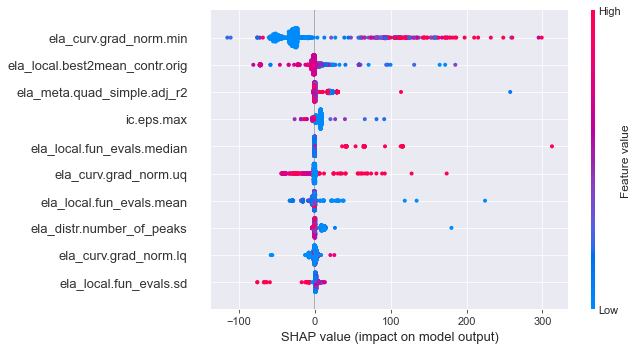

In [52]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current Label Shown: Precision \n')

shap.summary_plot(shap_values = shap_values[0],
                  features = model_multi.X_train, max_display=10
                  ) 

### Log Precision

Current Label Shown: Log Precision 



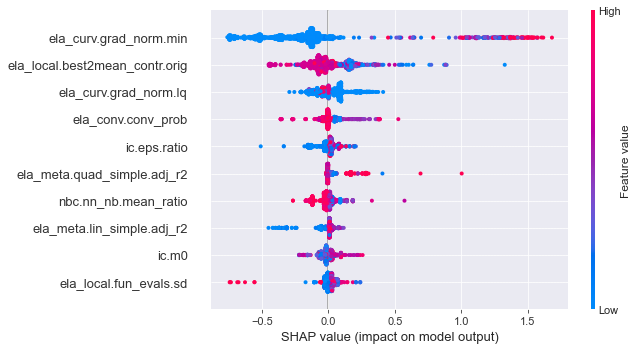

In [53]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current Label Shown: Log Precision \n')

shap.summary_plot(shap_values = shap_values[1],
                  features = model_multi.X_train, max_display=10
                  ) 

### SHAP Single Output Models

#### Precision

In [54]:
explainer = shap.TreeExplainer(model = model_single_precision.model)

Current Label Shown: Precision 



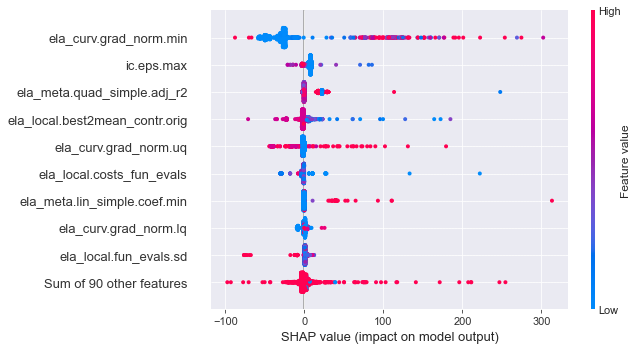

In [55]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current Label Shown: Precision \n')
shap_values = explainer(model_single_precision.X_train)

shap.plots.beeswarm(shap_values)

#### Log Precision

In [56]:
explainer = shap.TreeExplainer(model = model_single_log_precision.model)

Current Label Shown: Log Precision 



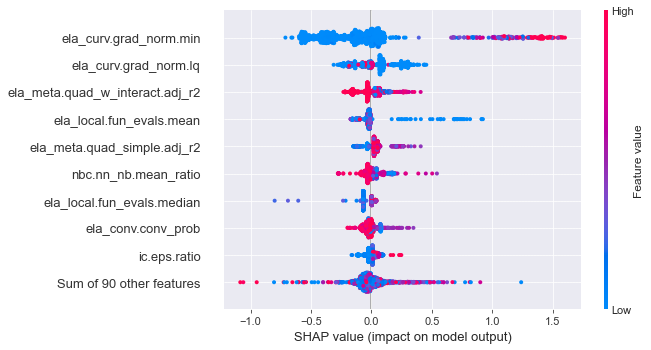

In [57]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current Label Shown: Log Precision \n')

shap_values = explainer(model_single_log_precision.X_train)

shap.plots.beeswarm(shap_values)

## MAE Single vs Multioutput

In [58]:
mae_merged_renamed = mae_merged_renamed.rename(columns={'Precision_single_output_mae': 'Precision Single-output MAE', 'Precision_multioutput_mae': 'Precision Multi-output MAE', 'log_Precision_single_output_mae': 'Log Precision Single-output MAE', 'log_Precision_multioutput_mae':'Log Precision Multi-output MAE'})

<AxesSubplot:xlabel='Fold'>

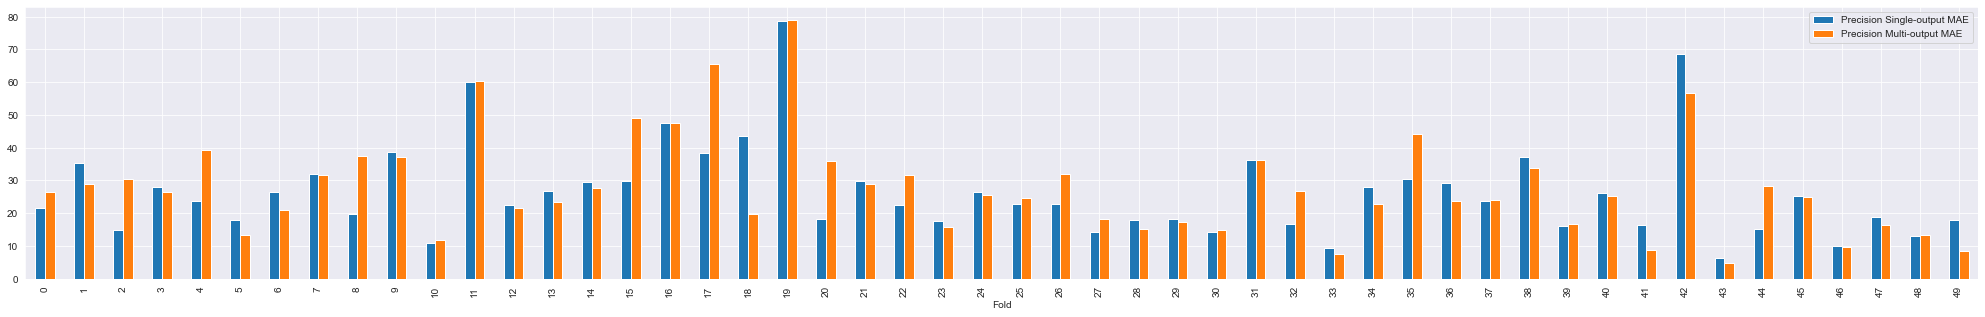

In [59]:
mae_merged_renamed.plot(x="Fold", y=["Precision Single-output MAE", "Precision Multi-output MAE"], kind="bar", figsize=(35,5), width = 0.5)

<AxesSubplot:xlabel='Fold'>

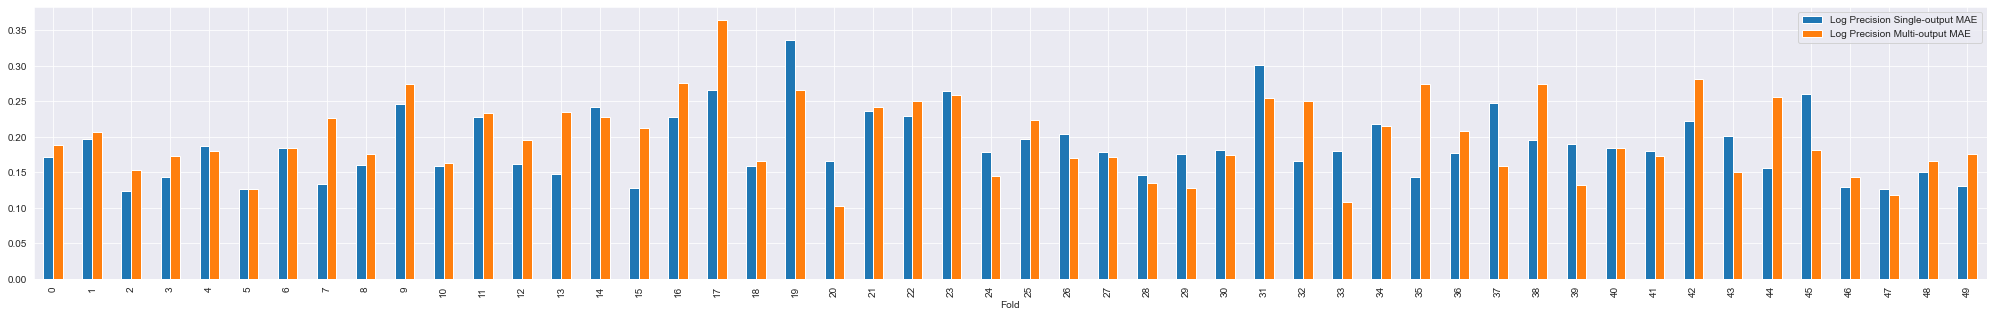

In [60]:
mae_merged_renamed.plot(x="Fold", y=["Log Precision Single-output MAE", "Log Precision Multi-output MAE"], kind="bar", figsize=(35,5), width = 0.5)

## MAE on function level

### Label: Precision

In [61]:
mae_fid = []

for i in range(1, 25):
  single_multi_precision_df_f_id_1 = single_multi_precision_df.loc[single_multi_precision_df['f_id'] == str(i)][["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real", "f_id"]]
  if not single_multi_precision_df_f_id_1.empty: 
    multi_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['Precision_prediction_multitarget'], single_multi_precision_df_f_id_1['Precision_real'])
    single_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['Precision_prediction_singletarget'], single_multi_precision_df_f_id_1['Precision_real'])
    mae_fid.append([i, multi_mae_function, single_mae_function])

mae_fid_df = pd.DataFrame(mae_fid, columns=['Function ID', 'Multi-output model MAE PRECISION', 'Single-output model MAE PRECISION'])

<AxesSubplot:xlabel='Function ID'>

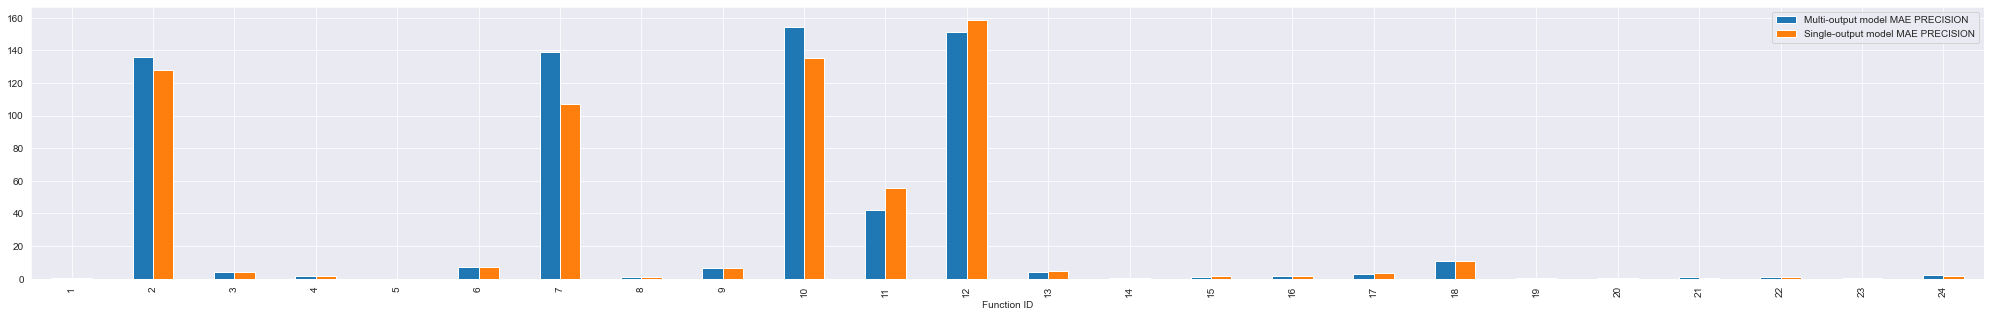

In [62]:
mae_fid_df.plot(x="Function ID", y=["Multi-output model MAE PRECISION", "Single-output model MAE PRECISION"], kind="bar", figsize=(35,5), width = 0.5)

In [63]:
mae_fid_df_less_10 = mae_fid_df[(mae_fid_df['Multi-output model MAE PRECISION'] < 10) & (mae_fid_df['Single-output model MAE PRECISION'] < 10)]
mae_fid_df_more_10 = mae_fid_df[(mae_fid_df['Multi-output model MAE PRECISION'] >= 10) & (mae_fid_df['Single-output model MAE PRECISION'] >= 10)]

In [64]:
mae_fid_df_less_10.columns = ['f_id', 'Multi-output model MAE PRECISION', 'Single-output model MAE PRECISION']
mae_fid_df_more_10.columns = ['f_id', 'Multi-output model MAE PRECISION', 'Single-output model MAE PRECISION']

In [65]:
# mae_fid_df['Multi_output_model_MAE_PRECISION_log_value'] = np.log(mae_fid_df['Multi_output_model_MAE_PRECISION'])
# mae_fid_df['Single_output_model_MAE_PRECISION_log_value'] = np.log(mae_fid_df['Single_output_model_MAE_PRECISION'])

* Functions with MAE less than 10 

<AxesSubplot:xlabel='f_id'>

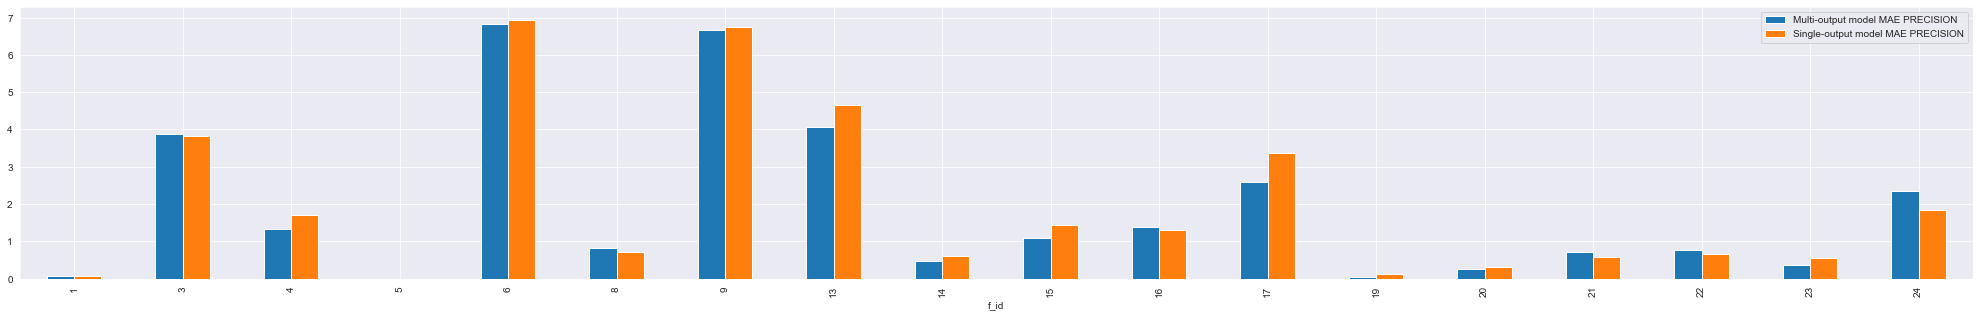

In [66]:
mae_fid_df_less_10.plot(x="f_id", y=["Multi-output model MAE PRECISION", "Single-output model MAE PRECISION"], kind="bar", figsize=(35,5), width = 0.5)

* Functions with MAE more than 10 

<AxesSubplot:xlabel='f_id'>

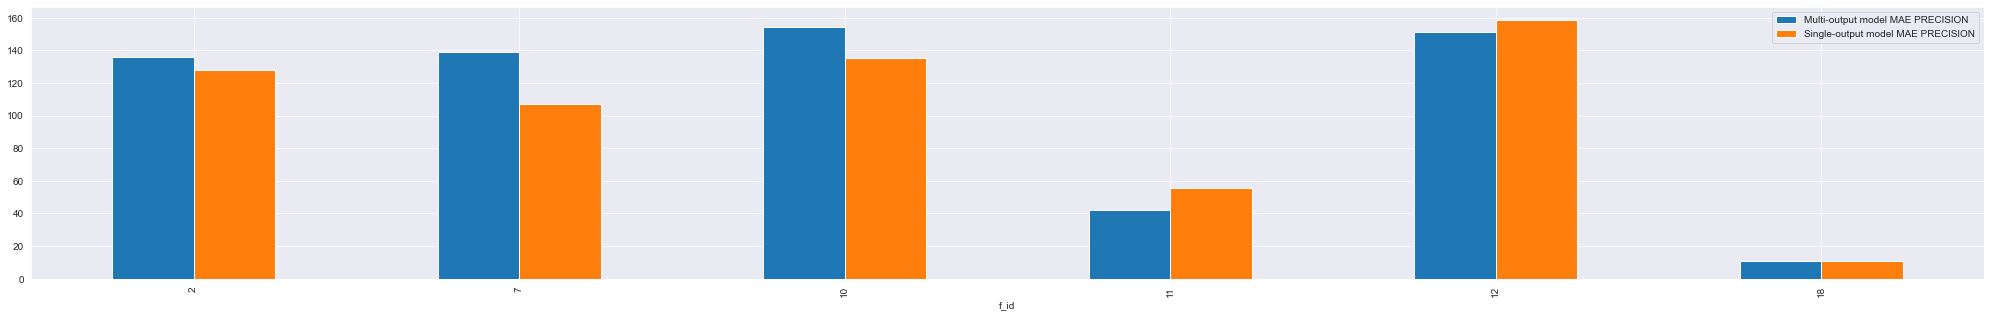

In [67]:
mae_fid_df_more_10.plot(x="f_id", y=["Multi-output model MAE PRECISION", "Single-output model MAE PRECISION"], kind="bar", figsize=(35,5), width = 0.5)

### Label: Log Precision

In [68]:
mae_fid = []

for i in range(1, 25):
  single_multi_precision_df_f_id_1 = single_multi_log_precision_df.loc[single_multi_log_precision_df['f_id'] == str(i)][["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real", "f_id"]]
  if not single_multi_precision_df_f_id_1.empty: 
    multi_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['log_Precision_prediction_multitarget'], single_multi_precision_df_f_id_1['log_Precision_real'])
    single_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['log_Precision_prediction_singletarget'], single_multi_precision_df_f_id_1['log_Precision_real'])
    mae_fid.append([i, multi_mae_function, single_mae_function])

mae_fid_df = pd.DataFrame(mae_fid, columns=['Function ID', 'Multi-output model MAE LOG PRECISION', 'Single-output model MAE LOG PRECISION'])

In [69]:
mae_fid_df_less_10 = mae_fid_df[(mae_fid_df['Multi-output model MAE LOG PRECISION'] < 10) & (mae_fid_df['Single-output model MAE LOG PRECISION'] < 10)]
mae_fid_df_more_10 = mae_fid_df[(mae_fid_df['Multi-output model MAE LOG PRECISION'] >= 10) & (mae_fid_df['Single-output model MAE LOG PRECISION'] >= 10)]

In [70]:
mae_fid_df_less_10.columns = ['f_id', 'Multi-output model MAE LOG PRECISION', 'Single-output model MAE LOG PRECISION']
mae_fid_df_more_10.columns = ['f_id', 'Multi-output model MAE LOG PRECISION', 'Single-output model MAE LOG PRECISION']

In [71]:
# mae_fid_df['Multi_output_model_MAE_PRECISION_log_value'] = np.log(mae_fid_df['Multi_output_model_MAE_PRECISION'])
# mae_fid_df['Single_output_model_MAE_PRECISION_log_value'] = np.log(mae_fid_df['Single_output_model_MAE_PRECISION'])

* Functions with MAE less than 10 

<AxesSubplot:xlabel='f_id'>

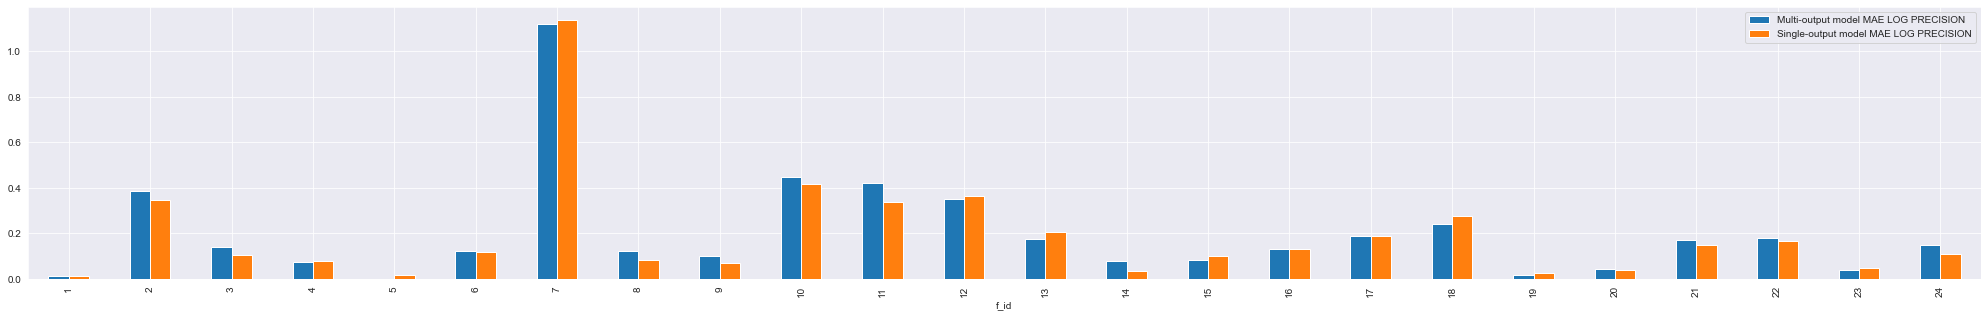

In [72]:
mae_fid_df_less_10.plot(x="f_id", y=["Multi-output model MAE LOG PRECISION", "Single-output model MAE LOG PRECISION"], kind="bar", figsize=(35,5), width = 0.5)

## Precision

In [73]:
single_multi_precision_df_melted['value_log'] = np.log(single_multi_precision_df_melted['value']+1)

In [74]:
single_multi_precision_df_melted.replace("Precision_prediction_multitarget", 'Precision Predictions Multi-output model', inplace=True)

In [75]:
single_multi_precision_df_melted.replace("Precision Predictions Multi-output model", 'Predictions Multi-output model', inplace=True)

In [76]:
single_multi_precision_df_melted.replace("Precision_prediction_singletarget", 'Predictions Single-output model', inplace=True)

In [77]:
single_multi_precision_df_melted.replace("Precision_real", 'Target', inplace=True)

In [78]:
single_multi_precision_df_melted.columns = ['Function ID', 'variable', 'Precision', 'Precision Log Scale']

In [79]:
domain_precision = ['Precision Predictions Multi-output model', 'Precision Predictions Single-output model', 'Precision Real']

In [80]:
alt.Chart(
    single_multi_precision_df_melted
).mark_circle(
).encode(
    alt.X('variable:N', title=''),
    alt.Y('Precision:Q'),
    column='Function ID:N',
    color='variable:N'
).properties(
    width = 100,
    height = 400
)

alt.Chart(...)

In [81]:
alt.Chart(
    single_multi_precision_df_melted
).mark_circle(
).encode(
    alt.X('variable:N', title=''),
    alt.Y('Precision Log Scale:Q'),
    column='Function ID:N',
    color='variable:N'
).properties(
    width = 100,
    height = 400
)

alt.Chart(...)

<AxesSubplot:xlabel='Function ID', ylabel='Precision Log Scale'>

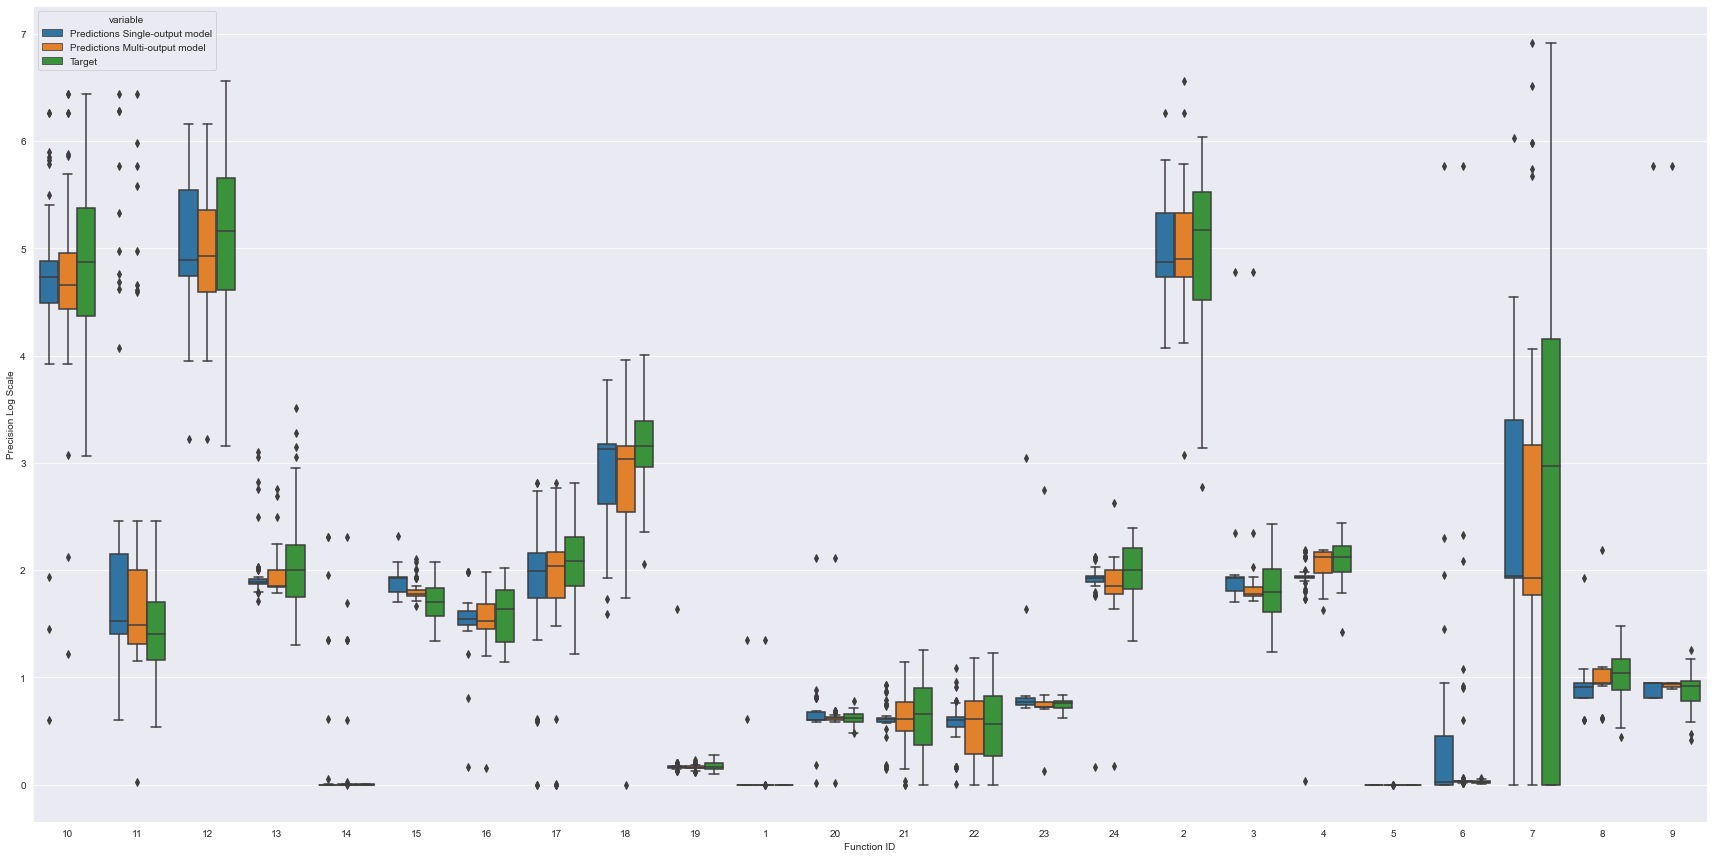

In [82]:
a4_dims = (30, 15)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, x='Function ID', y='Precision Log Scale', hue='variable', data=single_multi_precision_df_melted)

### Precision for a given function

In [83]:
f_id = '4'

In [84]:
single_multi_precision_df_f_id_1 = single_multi_precision_df.loc[single_multi_precision_df['f_id'] == f_id][["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real", "f_id"]]

In [85]:
single_multi_precision_df_f_id_1_melted = pd.melt(single_multi_precision_df_f_id_1, id_vars=['f_id'], value_vars=["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real"])

In [86]:
single_multi_precision_df_f_id_1_melted.replace("Precision_prediction_multitarget", 'Predictions Multi-output model', inplace=True)
single_multi_precision_df_f_id_1_melted.replace("Precision_prediction_singletarget", 'Predictions Single-output model', inplace=True)
single_multi_precision_df_f_id_1_melted.replace("Precision_real", 'Target', inplace=True)

In [87]:
single_multi_precision_df_f_id_1_melted['value_log'] = np.log(single_multi_precision_df_f_id_1_melted['value'])

In [88]:
single_multi_precision_df_f_id_1_melted.columns = ['Function ID', 'variable', 'Precision', 'Precision Log Scale']

<AxesSubplot:xlabel='Function ID', ylabel='Precision Log Scale'>

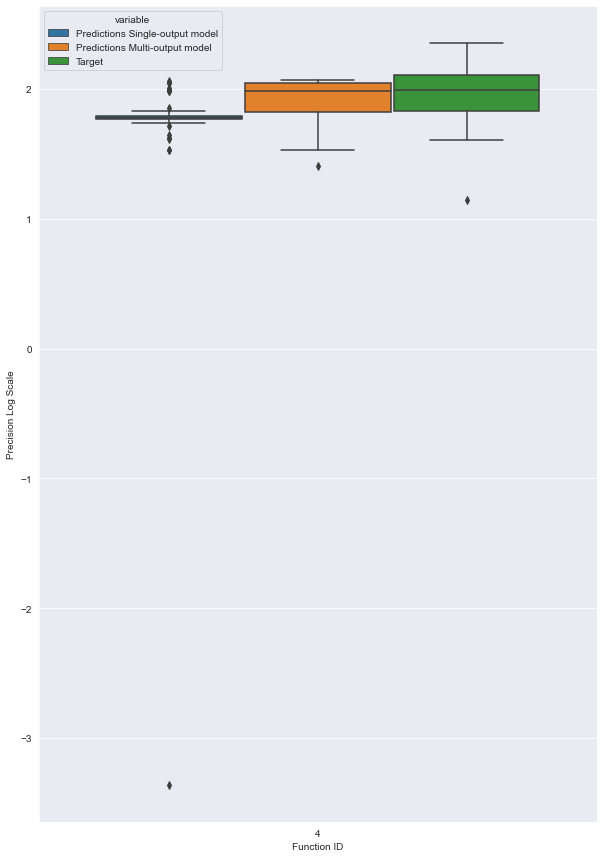

In [89]:
a4_dims = (10, 15)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, x='Function ID', y='Precision Log Scale', hue='variable', data=single_multi_precision_df_f_id_1_melted)

In [90]:
alt.Chart(single_multi_precision_df_f_id_1_melted).mark_circle().encode(
    x='variable:O',
    y='Precision Log Scale:Q',
    color = 'variable'
).properties(
    width = 400,
    height = 600
)

alt.Chart(...)

### Precision for a given function

In [91]:
f_id = '13'

In [92]:
single_multi_precision_df_f_id_1 = single_multi_precision_df.loc[single_multi_precision_df['f_id'] == f_id][["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real", "f_id"]]

In [93]:
single_multi_precision_df_f_id_1_melted = pd.melt(single_multi_precision_df_f_id_1, id_vars=['f_id'], value_vars=["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real"])

In [94]:
single_multi_precision_df_f_id_1_melted.replace("Precision_prediction_multitarget", 'Predictions Multi-output model', inplace=True)
single_multi_precision_df_f_id_1_melted.replace("Precision_prediction_singletarget", 'Predictions Single-output model', inplace=True)
single_multi_precision_df_f_id_1_melted.replace("Precision_real", 'Target', inplace=True)

In [95]:
single_multi_precision_df_f_id_1_melted['value_log'] = np.log(single_multi_precision_df_f_id_1_melted['value'])

In [96]:
single_multi_precision_df_f_id_1_melted.columns = ['Function ID', 'variable', 'Precision', 'Precision Log Scale']

<AxesSubplot:xlabel='Function ID', ylabel='Precision Log Scale'>

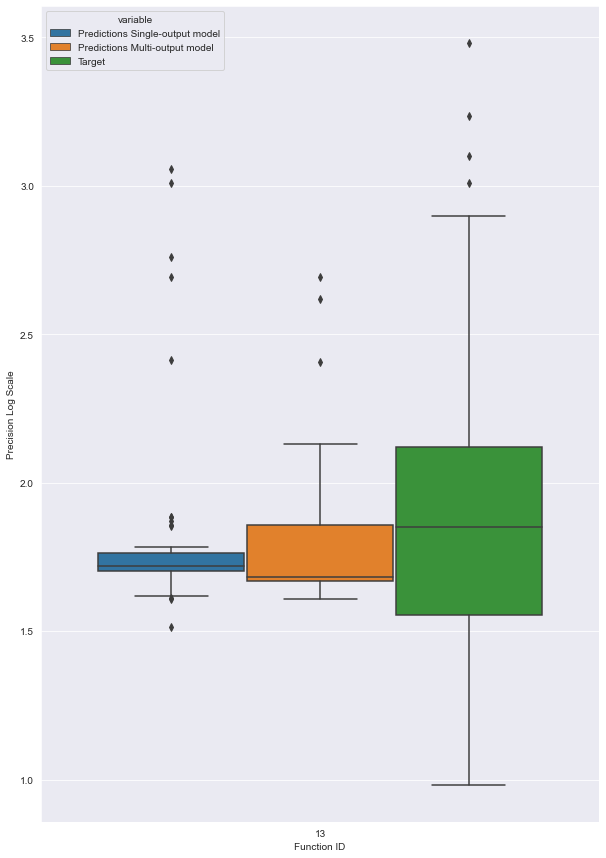

In [97]:
a4_dims = (10, 15)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, x='Function ID', y='Precision Log Scale', hue='variable', data=single_multi_precision_df_f_id_1_melted)

In [98]:
alt.Chart(single_multi_precision_df_f_id_1_melted).mark_circle().encode(
    x='variable:O',
    y='Precision Log Scale:Q',
    color = 'variable'
).properties(
    width = 400,
    height = 600
)

alt.Chart(...)

## Log Precision

In [99]:
single_multi_log_precision_df_melted.replace("log_Precision_prediction_multitarget", 'Log Predictions Multi-output model', inplace=True)
single_multi_log_precision_df_melted.replace("log_Precision_prediction_singletarget", 'Log Predictions Single-output model', inplace=True)
single_multi_log_precision_df_melted.replace("log_Precision_real", 'Target', inplace=True)

In [100]:
single_multi_precision_df_melted

,Function ID,variable,Precision,Precision Log Scale
0,10,Predictions Single-output model,111.990395,4.727303
1,11,Predictions Single-output model,3.594082,1.524769
2,12,Predictions Single-output model,316.265350,5.759738
3,13,Predictions Single-output model,15.821165,2.822638
4,14,Predictions Single-output model,0.000644,0.000644
...,...,...,...,...
3595,5,Target,0.000000,0.000000
3596,6,Target,0.047494,0.046400
3597,7,Target,15.546400,2.806169
3598,8,Target,1.946011,1.080452


In [101]:
single_multi_log_precision_df_melted.columns = ['Function ID', 'variable', 'Log Precision']

In [102]:
alt.Chart(
    single_multi_log_precision_df_melted
).mark_circle(
).encode(
    alt.X('variable:N', title=''),
    alt.Y('Log Precision:Q'),
    column='Function ID:N',
    color='variable:N'
).properties(
    width = 100,
    height = 400
)

alt.Chart(...)

<AxesSubplot:xlabel='Function ID', ylabel='Log Precision'>

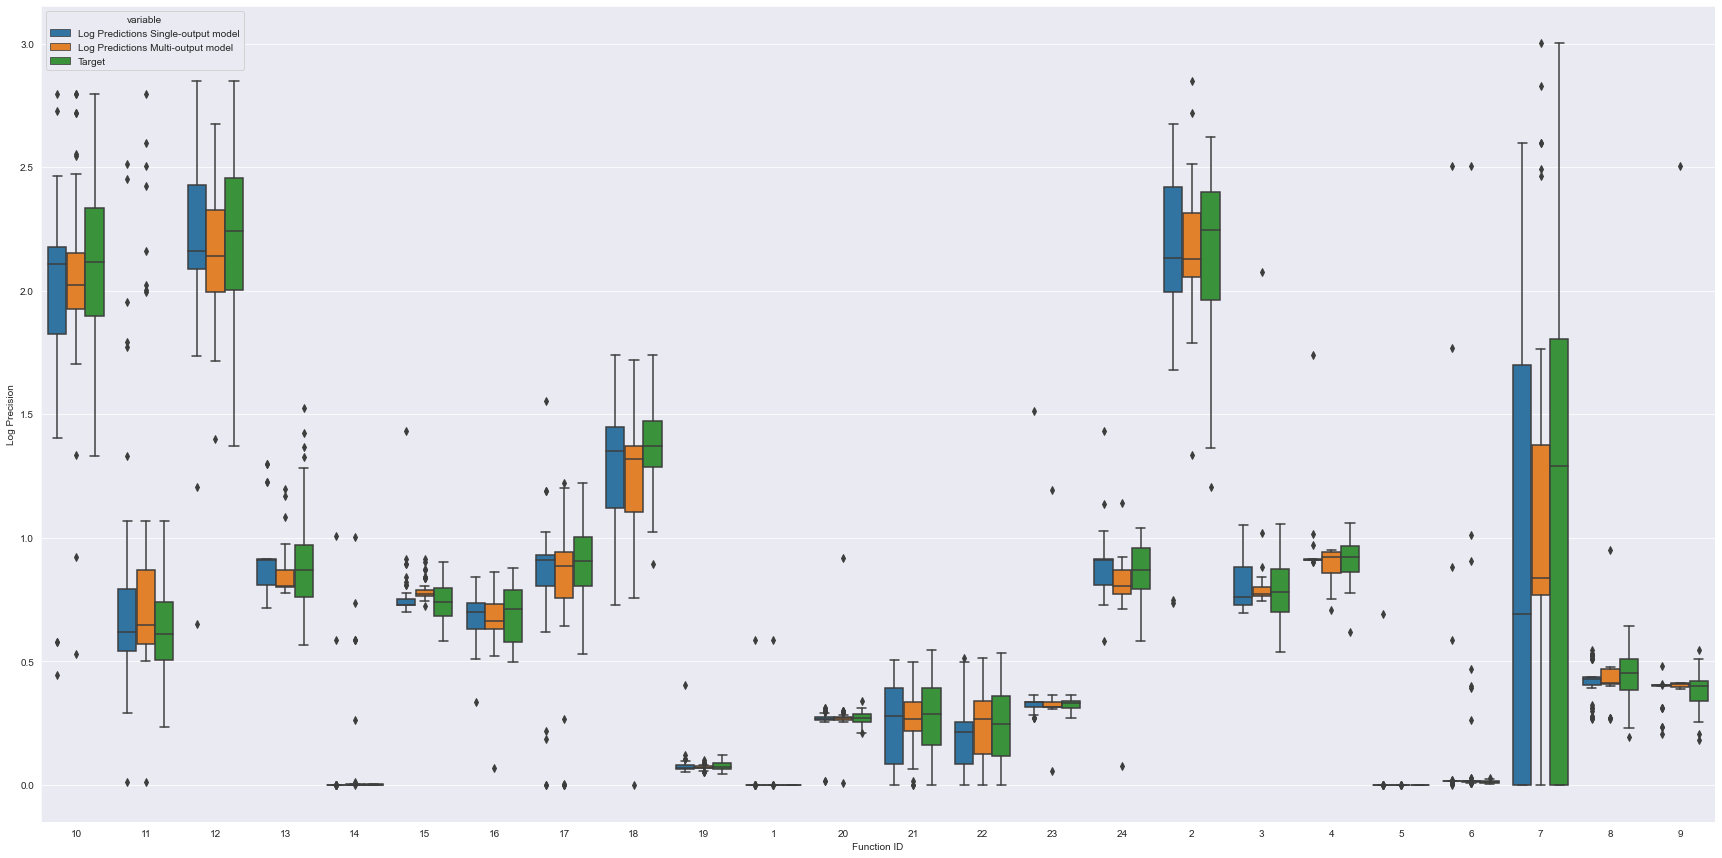

In [103]:
a4_dims = (30, 15)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, x='Function ID', y='Log Precision', hue='variable', data=single_multi_log_precision_df_melted)

### Precision for a given function

In [104]:
f_id = '4'

In [105]:
single_multi_log_precision_df_f_id_1 = single_multi_log_precision_df.loc[single_multi_log_precision_df['f_id'] == f_id][["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real", "f_id"]]

In [106]:
single_multi_log_precision_df_f_id_1_melted = pd.melt(single_multi_log_precision_df_f_id_1, id_vars=['f_id'], value_vars=["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real"])

In [107]:
single_multi_log_precision_df_f_id_1_melted.replace("log_Precision_prediction_multitarget", 'Predictions Multi-output model', inplace=True)
single_multi_log_precision_df_f_id_1_melted.replace("log_Precision_prediction_singletarget", 'Predictions Single-output model', inplace=True)
single_multi_log_precision_df_f_id_1_melted.replace("log_Precision_real", 'Target', inplace=True)

In [108]:
single_multi_log_precision_df_f_id_1_melted.columns = ['Function ID', 'variable', 'Log Precision']

<AxesSubplot:xlabel='Function ID', ylabel='Log Precision'>

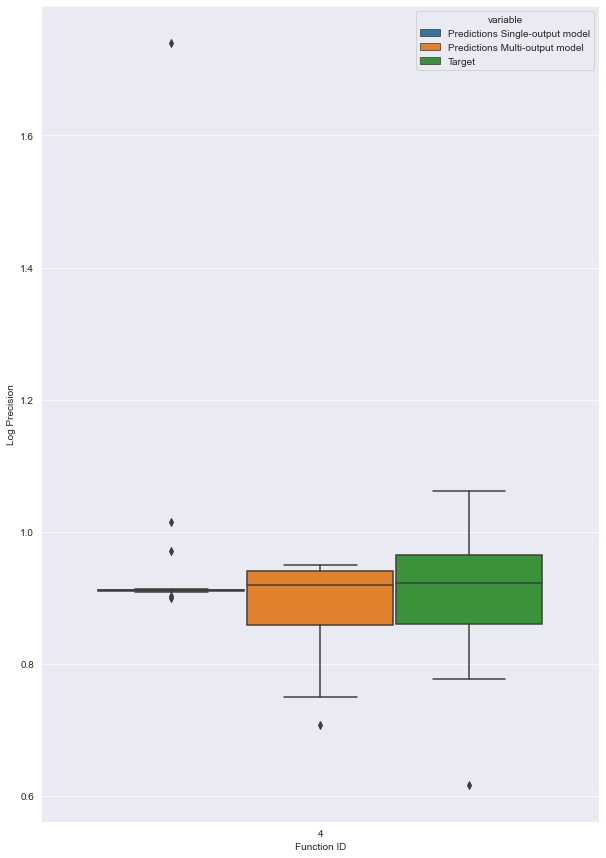

In [109]:
a4_dims = (10, 15)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, x='Function ID', y='Log Precision', hue='variable', data=single_multi_log_precision_df_f_id_1_melted)

In [110]:
alt.Chart(single_multi_log_precision_df_f_id_1_melted).mark_circle().encode(
    x='variable:O',
    y='Log Precision:Q',
    color = 'variable'
).properties(
    width = 400,
    height = 600
)

alt.Chart(...)

### Precision for a given function

In [111]:
f_id = '13'

In [112]:
single_multi_log_precision_df_f_id_1 = single_multi_log_precision_df.loc[single_multi_log_precision_df['f_id'] == f_id][["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real", "f_id"]]

In [113]:
single_multi_log_precision_df_f_id_1_melted = pd.melt(single_multi_log_precision_df_f_id_1, id_vars=['f_id'], value_vars=["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real"])

In [114]:
single_multi_log_precision_df_f_id_1_melted.replace("log_Precision_prediction_multitarget", 'Predictions Multi-output model', inplace=True)
single_multi_log_precision_df_f_id_1_melted.replace("log_Precision_prediction_singletarget", 'Predictions Single-output model', inplace=True)
single_multi_log_precision_df_f_id_1_melted.replace("log_Precision_real", 'Target', inplace=True)

In [115]:
single_multi_log_precision_df_f_id_1_melted.columns = ['Function ID', 'variable', 'Log Precision']

<AxesSubplot:xlabel='Function ID', ylabel='Log Precision'>

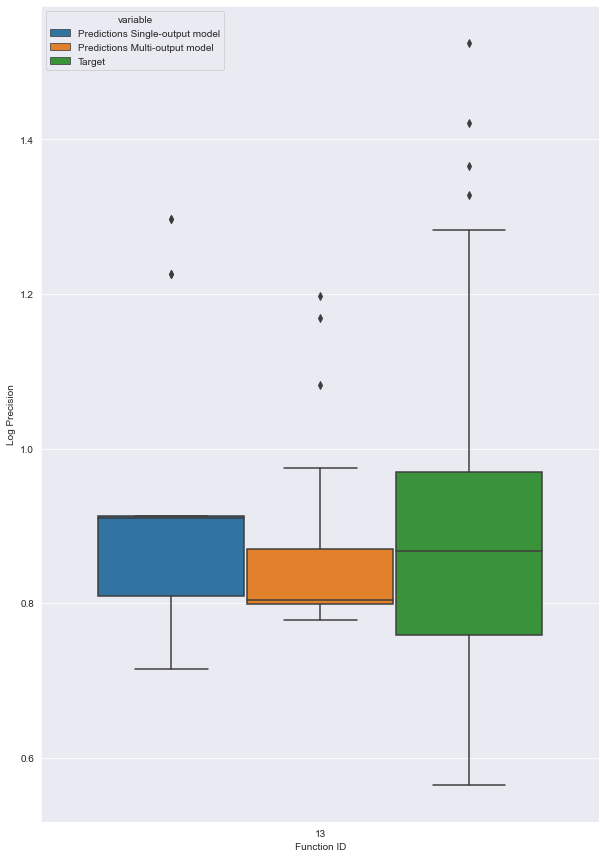

In [116]:
a4_dims = (10, 15)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, x='Function ID', y='Log Precision', hue='variable', data=single_multi_log_precision_df_f_id_1_melted)

In [117]:
alt.Chart(single_multi_log_precision_df_f_id_1_melted).mark_circle().encode(
    x='variable:O',
    y='Log Precision:Q',
    color = 'variable'
).properties(
    width = 400,
    height = 600
)

alt.Chart(...)

# Export

## Shap to CSV

### Multi Model

In [118]:
for i in range(50):
  filename = f"{models_folder}{multi_target_folder}{regression_multi}model_fold_no_{i}_alg_no_{algorithm_no}.pkl"
  model_multi = pickle.load(open(filename, 'rb'))

  f_id_dict, asd = get_dictonary_function_id_with_index(model_multi.X_train)

  explainer = shap.TreeExplainer(model = model_multi.model)

  shap_values = explainer.shap_values(X = model_multi.X_train)

  file_name_precision_alg_level = shap_algorithm_level_folder_multi_precision + f'precision_shaps_fold_no_{i}.csv'
  file_name_log_precision_alg_level = shap_algorithm_level_folder_multi_log_precision + f'log_precision_shaps_fold_no_{i}.csv'
  precision_shaps_alg_level = pd.DataFrame(shap_values[0], columns=model_multi.X_train.columns)
  log_precision_shaps_alg_level = pd.DataFrame(shap_values[1], columns=model_multi.X_train.columns)
  precision_shaps_alg_level.to_csv(file_name_precision_alg_level, index=False)
  log_precision_shaps_alg_level.to_csv(file_name_log_precision_alg_level, index=False)

  f_id_shap_values = []
  for f_id, indexes in f_id_dict.items():
    file_name_precision = shap_function_level_folder_multi_precision + f'function_{f_id}_precision_shaps_fold_no_{i}.csv'
    file_name_log_precision = shap_function_level_folder_multi_log_precision + f'function_{f_id}_log_precision_shaps_fold_no_{i}.csv'
    shap_values = explainer.shap_values(X = model_multi.X_train.iloc[f_id_dict.get(str(f_id)), :])
    precision_shaps = pd.DataFrame(shap_values[0], columns=model_multi.X_train.columns)
    log_precision_shaps = pd.DataFrame(shap_values[1], columns=model_multi.X_train.columns)
    precision_shaps.to_csv(file_name_precision, index=False)
    log_precision_shaps.to_csv(file_name_log_precision, index=False)


KeyboardInterrupt: 

### Single Model

#### Precision

In [ ]:
for i in range(50):
  filename = f"{models_folder}{single_output_folder}{regression_single}model_fold_no_{i}_alg_no_{algorithm_no}_label_Precision.pkl"
  model_single_precision = pickle.load(open(filename, 'rb'))

  f_id_dict, asd = get_dictonary_function_id_with_index(model_single_precision.X_train)

  explainer = shap.TreeExplainer(model = model_single_precision.model)

  shap_values = explainer.shap_values(X = model_single_precision.X_train)

  file_name_precision_alg_level = shap_algorithm_level_folder_single_precision + f'precision_shaps_fold_no_{i}.csv'
  #file_name_log_precision_alg_level = shap_algorithm_level_folder_multi_log_precision + f'log_precision_shaps.csv'
  precision_shaps_alg_level = pd.DataFrame(shap_values, columns=model_single_precision.X_train.columns)
  #log_precision_shaps_alg_level = pd.DataFrame(shap_values[1], columns=model_multi.X_train.columns)
  precision_shaps_alg_level.to_csv(file_name_precision_alg_level)
  #log_precision_shaps_alg_level.to_csv(file_name_log_precision_alg_level)

  f_id_shap_values = []
  for f_id, indexes in f_id_dict.items():
    file_name_precision = shap_function_level_folder_single_precision  + f'function_{f_id}_precision_shaps_fold_no_{i}.csv'
    #file_name_log_precision = shap_function_level_folder_multi_log_precision + f'function_{f_id}_log_precision_shaps.csv'
    shap_values = explainer.shap_values(X = model_single_precision.X_train.iloc[f_id_dict.get(str(f_id)), :])
    precision_shaps = pd.DataFrame(shap_values, columns=model_single_precision.X_train.columns)
    #log_precision_shaps = pd.DataFrame(shap_values[1], columns=model_multi.X_train.columns)
    precision_shaps.to_csv(file_name_precision, index=False)
    #log_precision_shaps.to_csv(file_name_log_precision)


#### Log Precision

In [ ]:
for i in range(50):
  filename = f"{models_folder}{single_output_folder}{regression_single}model_fold_no_{i}_alg_no_{algorithm_no}_label_log_Precision.pkl"
  model_single_log_precision = pickle.load(open(filename, 'rb'))

  f_id_dict, asd = get_dictonary_function_id_with_index(model_single_log_precision.X_train)

  explainer = shap.TreeExplainer(model = model_single_log_precision.model)

  shap_values = explainer.shap_values(X = model_single_log_precision.X_train)

  #file_name_precision_alg_level = shap_algorithm_level_folder_single_precision + f'precision_shaps.csv'
  file_name_log_precision_alg_level = shap_algorithm_level_folder_single_log_precision  + f'log_precision_shaps_fold_no_{i}.csv'
  #precision_shaps_alg_level = pd.DataFrame(shap_values, columns=model_single_precision.X_train.columns)
  log_precision_shaps_alg_level = pd.DataFrame(shap_values, columns=model_single_log_precision.X_train.columns)
  #precision_shaps_alg_level.to_csv(file_name_precision_alg_level)
  log_precision_shaps_alg_level.to_csv(file_name_log_precision_alg_level)

  f_id_shap_values = []
  for f_id, indexes in f_id_dict.items():
    #file_name_precision = shap_function_level_folder_single_log_precision   + f'function_{f_id}_precision_shaps.csv'
    file_name_log_precision = shap_function_level_folder_single_log_precision + f'function_{f_id}_log_precision_shaps_fold_no_{i}.csv'
    shap_values = explainer.shap_values(X = model_single_log_precision.X_train.iloc[f_id_dict.get(str(f_id)), :])
    #precision_shaps = pd.DataFrame(shap_values, columns=model_single_log_precision.X_train.columns)
    log_precision_shaps = pd.DataFrame(shap_values, columns=model_single_log_precision.X_train.columns)
    #precision_shaps.to_csv(file_name_precision, index=False)
    log_precision_shaps.to_csv(file_name_log_precision)


In [ ]:
drive.flush_and_unmount()

## MAE to Csv

### Function Level

In [ ]:
mae_fid = []
mae_fid_multi = []
mae_fid_single = []
for i in range(1, 25):
  single_multi_precision_df_f_id_1 = single_multi_precision_df.loc[single_multi_precision_df['f_id'] == str(i)][["Precision_prediction_singletarget", "Precision_prediction_multitarget", "Precision_real", "f_id"]]
  if not single_multi_precision_df_f_id_1.empty: 
    multi_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['Precision_prediction_multitarget'], single_multi_precision_df_f_id_1['Precision_real'])
    single_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['Precision_prediction_singletarget'], single_multi_precision_df_f_id_1['Precision_real'])
    mae_fid.append([i, multi_mae_function, single_mae_function])
    mae_fid_multi.append([i, multi_mae_function])
    mae_fid_single.append([i, single_mae_function])

mae_fid_df = pd.DataFrame(mae_fid, columns=['f_id', 'Multi_output_model_MAE_PRECISION', 'Single_output_model_MAE_PRECISION'])
mae_fid_multi = pd.DataFrame(mae_fid_multi, columns=['f_id', 'MAE'])
mae_fid_single = pd.DataFrame(mae_fid_single, columns=['f_id', 'MAE'])

In [ ]:
file_name_mae_multi_precision = mae_funtion_level_folder_multi_precision + f'function_level_mae.csv'
file_name_mae_single_precision = mae_funtion_level_folder_single_precision  + f'function_level_mae.csv'

In [ ]:
single_multi_precision_df.shape

In [ ]:
mae_fid_multi.to_csv(file_name_mae_multi_precision, index=False)
mae_fid_single.to_csv(file_name_mae_single_precision, index=False)

In [ ]:
mae_fid = []
mae_fid_multi = []
mae_fid_single = []

for i in range(1, 25):
  single_multi_precision_df_f_id_1 = single_multi_log_precision_df.loc[single_multi_log_precision_df['f_id'] == str(i)][["log_Precision_prediction_singletarget", "log_Precision_prediction_multitarget", "log_Precision_real", "f_id"]]
  if not single_multi_precision_df_f_id_1.empty: 
    multi_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['log_Precision_prediction_multitarget'], single_multi_precision_df_f_id_1['log_Precision_real'])
    single_mae_function = mean_absolute_error(single_multi_precision_df_f_id_1['log_Precision_prediction_singletarget'], single_multi_precision_df_f_id_1['log_Precision_real'])
    mae_fid.append([i, multi_mae_function, single_mae_function])
    mae_fid_multi.append([i, multi_mae_function])
    mae_fid_single.append([i, single_mae_function])

mae_fid_df = pd.DataFrame(mae_fid, columns=['f_id', 'Multi_output_model_MAE_LOG_PRECISION', 'Single_output_model_MAE_LOG_PRECISION'])
mae_fid_multi = pd.DataFrame(mae_fid_multi, columns=['f_id', 'MAE'])
mae_fid_single = pd.DataFrame(mae_fid_single, columns=['f_id', 'MAE'])

In [ ]:
file_name_mae_multi_precision = mae_funtion_level_folder_multi_log_precision  + f'function_level_mae.csv'
file_name_mae_single_precision = mae_funtion_level_folder_single_log_precision   + f'function_level_mae.csv'

In [ ]:
mae_fid_multi.to_csv(file_name_mae_multi_precision, index=False)
mae_fid_single.to_csv(file_name_mae_single_precision, index=False)

### Fold Level

In [ ]:
mae_precision_single = mae_merged_renamed[['Fold', 'Precision_single_output_mae']]
mae_log_precision_single = mae_merged_renamed[['Fold', 'log_Precision_single_output_mae']]
mae_precision_multi = mae_merged_renamed[['Fold', 'Precision_multioutput_mae']]
mae_log_precision_multi = mae_merged_renamed[['Fold', 'log_Precision_multioutput_mae']]

In [ ]:
mae_precision_multi_file_name = mae_algorithm_level_folder_multi_precision  + f'fold_level_mae.csv'
mae_log_precision_multi_file_name = mae_algorithm_level_folder_multi_log_precision + f'fold_level_mae.csv'
mae_precision_single_file_name = mae_algorithm_level_folder_single_precision + f'fold_level_mae.csv'
mae_log_precision_single_file_name = mae_algorithm_level_folder_single_log_precision + f'fold_level_mae.csv'

In [ ]:
mae_precision_multi.to_csv(mae_precision_multi_file_name)
mae_log_precision_multi.to_csv(mae_log_precision_multi_file_name)
mae_precision_single.to_csv(mae_precision_single_file_name)
mae_log_precision_single.to_csv(mae_log_precision_single_file_name)

In [ ]:
# If you are using Google Colab uncomment next line

# drive.flush_and_unmount()